In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submit.csv", header = None)

In [3]:
train.head()

,id,age,sex,bmi,children,smoker,region,charges
0,0,26,male,32.665465,3,no,southeast,0
1,1,41,male,29.798725,1,no,southwest,0
2,2,28,male,32.722029,0,yes,northwest,1
3,3,20,female,38.429831,2,no,southeast,0
4,4,45,female,29.641854,1,no,northwest,0


In [4]:
# 年齢を6つのグループに分ける
train.loc[ train['age'] <= 19, 'age']                          = 0
train.loc[(train['age'] > 19) & (train['age'] <= 29), 'age'] = 1
train.loc[(train['age'] > 29) & (train['age'] <= 39), 'age'] = 2
train.loc[(train['age'] > 39) & (train['age'] <= 49), 'age'] = 3
train.loc[(train['age'] > 49) & (train['age'] <= 59), 'age'] = 4
train.loc[ train['age'] > 59, 'age'] = 5 ;

In [5]:
# BMIを6つのグループに分ける
train.loc[ train['bmi'] < 18.5, 'bmi']                          = 0
train.loc[(train['bmi'] >= 18.5) & (train['bmi'] < 25), 'bmi'] = 1
train.loc[(train['bmi'] >= 25) & (train['bmi'] < 30), 'bmi'] = 2
train.loc[(train['bmi'] >= 30) & (train['bmi'] < 35), 'bmi'] = 3
train.loc[(train['bmi'] >= 35) & (train['bmi'] < 40), 'bmi'] = 4
train.loc[ train['bmi'] >= 40, 'bmi'] = 5 ;

In [6]:
train["sex"].replace(["male", "female"],[0,1], inplace=True)
train["smoker"].replace(["no","yes"],[0,1], inplace=True)
train["region"].replace(["northwest","northeast","southwest","southeast"],[0,1,2,3], inplace=True)

In [7]:
train

,id,age,sex,bmi,children,smoker,region,charges
0,0,1,0,3.0,3,0,3,0
1,1,3,0,2.0,1,0,2,0
2,2,1,0,3.0,0,1,0,1
3,3,1,1,4.0,2,0,3,0
4,4,3,1,2.0,1,0,0,0
...,...,...,...,...,...,...,...,...
1595,1994,4,0,3.0,0,0,2,0
1596,1996,1,0,4.0,0,0,0,0
1597,1997,4,1,5.0,1,0,3,0
1598,1998,4,0,2.0,1,1,0,0


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

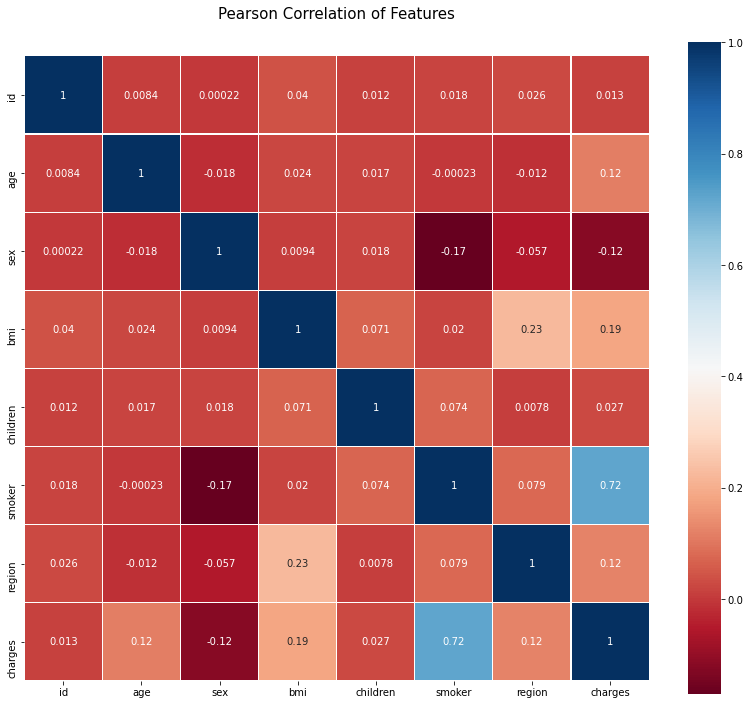

In [8]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

/Users/taiyo/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


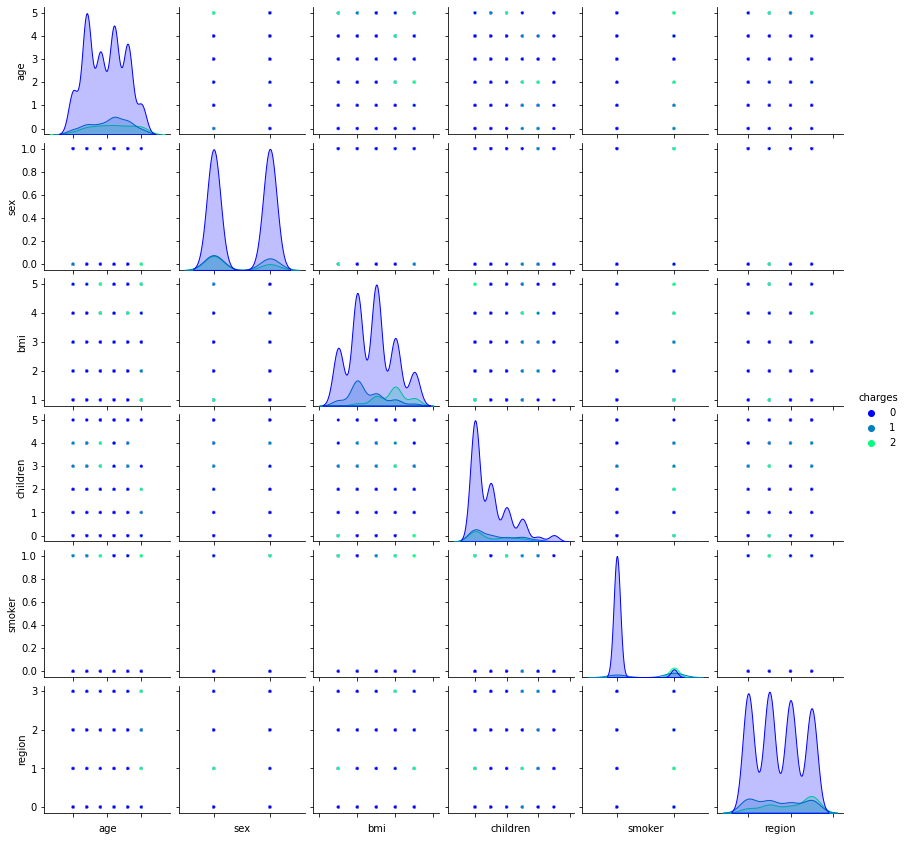

In [9]:
g = sns.pairplot(train[[u'age', u'sex', u'bmi', u'children', u'smoker', u'region', u'charges']], hue='charges', palette='winter',size=2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

In [10]:
trainX = train.iloc[:,0:7]

In [11]:
trainX

,id,age,sex,bmi,children,smoker,region
0,0,1,0,3.0,3,0,3
1,1,3,0,2.0,1,0,2
2,2,1,0,3.0,0,1,0
3,3,1,1,4.0,2,0,3
4,4,3,1,2.0,1,0,0
...,...,...,...,...,...,...,...
1595,1994,4,0,3.0,0,0,2
1596,1996,1,0,4.0,0,0,0
1597,1997,4,1,5.0,1,0,3
1598,1998,4,0,2.0,1,1,0


In [12]:
y = train.iloc[:,7:]

In [13]:
y

,charges
0,0
1,0
2,1
3,0
4,0
...,...
1595,0
1596,0
1597,0
1598,0


In [14]:
test.head()

,id,age,sex,bmi,children,smoker,region
0,13,19,male,24.365178,1,no,northeast
1,23,59,male,33.997763,0,yes,northeast
2,27,42,female,29.283450,0,no,southwest
3,28,30,male,24.903725,1,no,northwest
4,29,41,female,29.644536,0,no,southwest


In [15]:
testX = test.copy()

In [16]:
# 年齢を6つのグループに分ける
testX.loc[ testX['age'] <= 19, 'age']                          = 0
testX.loc[(testX['age'] > 19) & (testX['age'] <= 29), 'age'] = 1
testX.loc[(testX['age'] > 29) & (testX['age'] <= 39), 'age'] = 2
testX.loc[(testX['age'] > 39) & (testX['age'] <= 49), 'age'] = 3
testX.loc[(testX['age'] > 49) & (testX['age'] <= 59), 'age'] = 4
testX.loc[ testX['age'] > 59, 'age'] = 5 ;

In [17]:
# BMIを6つのグループに分ける
testX.loc[ testX['bmi'] < 18.5, 'bmi']                          = 0
testX.loc[(testX['bmi'] >= 18.5) & (testX['bmi'] < 25), 'bmi'] = 1
testX.loc[(testX['bmi'] >= 25) & (testX['bmi'] < 30), 'bmi'] = 2
testX.loc[(testX['bmi'] >= 30) & (testX['bmi'] < 35), 'bmi'] = 3
testX.loc[(testX['bmi'] >= 35) & (testX['bmi'] < 40), 'bmi'] = 4
testX.loc[ testX['bmi'] >= 40, 'bmi'] = 5 ;

In [18]:
testX["sex"].replace(["male", "female"],[0,1], inplace=True)
testX["smoker"].replace(["no","yes"],[0,1], inplace=True)
testX["region"].replace(["northwest","northeast","southwest","southeast"],[0,1,2,3], inplace=True)

In [19]:
testX

,id,age,sex,bmi,children,smoker,region
0,13,0,0,1.0,1,0,1
1,23,4,0,3.0,0,1,1
2,27,3,1,2.0,0,0,2
3,28,2,0,1.0,1,0,0
4,29,3,1,2.0,0,0,2
...,...,...,...,...,...,...,...
395,1968,3,1,1.0,1,0,0
396,1972,0,1,5.0,0,0,3
397,1979,2,1,4.0,0,1,3
398,1983,1,0,3.0,1,0,0


In [20]:
#clf1 = DT(max_depth=6,min_samples_leaf=10)

In [21]:
#clf1.fit(trainX,y)

In [22]:
#export_graphviz(clf1, out_file="tree.dot", feature_names=trainX.columns, class_names=["0","1","2"], filled=True, rounded=True)

In [23]:
#g = pydotplus.graph_from_dot_file(path="tree.dot")
#Image(g.create_png())

In [24]:
#pred = clf1.predict(testX)

In [25]:
#pred

In [26]:
#sample[1] = pred

In [27]:
#sample.to_csv("submit2_1.csv",index=None,header=None)

In [28]:
clf2 =DT()

In [29]:
parameters2 = {"max_depth":list(range(2,11)),"min_samples_leaf":[5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]}

In [30]:
gcv2 = GridSearchCV(clf2, parameters2, cv=5, scoring="roc_auc",n_jobs=-1)
gcv2.fit(trainX, y)

/Users/taiyo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [5, 10, 20, 30, 40, 50, 60, 70, 80,
                                              90, 100, 120, 140, 160, 180,
                                              200]},
             scoring='roc_auc')

In [31]:
gcv2.best_params_

{'max_depth': 2, 'min_samples_leaf': 5}

In [34]:
pred2 = gcv2.predict(testX)

In [35]:
pred2

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1,
       0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0,
       0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2,
       0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [36]:
sample[1] = pred2
sample.to_csv("submit3_3.csv",index=None,header=None)